# Vehicle Detection and Tracking

Importing necessary libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from numpy import random
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from moviepy.editor import VideoFileClip

%matplotlib inline

## Color and HOG features extraction

In [2]:
# Computes binned color features  
def bin_spatial(img, size=(32, 32)):
    # Using cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Returnig the feature vector
    return features


# Computes color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Computing the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenating the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Returning the individual histograms, bin_centers and feature vector
    return hist_features


# Gets HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Calling with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise calling with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Method to extract the combined HOG and color features

In [3]:
# Extracts the combined HOG and color features
def extract_features(imgs, cspace='RGB', 
                     spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Creating a list to append feature vectors to
    features = []
    # Iterating through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        # applying color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        # Applying bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Applying color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Calling get_hog_features() with vis=False, feature_vec=True
        # to get the HOG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(
                    get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        # Appending the new feature vector to the features list
        features.append(np.ravel(np.hstack((spatial_features, hist_features, hog_features))))
    # Returning the list of feature vectors
    return features

## Training a Classifier

### Getting image samples for training/test set

In [4]:
NO_SAMPLES_PER_CLASS = 1000

cars = []
notcars = []

cars_images = random.choice(glob.glob('training_images/vehicles/*/*.png'), NO_SAMPLES_PER_CLASS)
for image in cars_images:
    cars.append(image)

notcars_images = random.choice(glob.glob('training_images/non-vehicles/*/*.png'), NO_SAMPLES_PER_CLASS)
for image in notcars_images:
    notcars.append(image)

Testing sample data

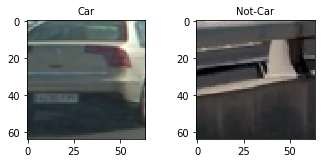

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 3))
f.tight_layout()
ax1.imshow(mpimg.imread(random.choice(cars)))
ax1.set_title('Car', fontsize=10)
ax2.imshow(mpimg.imread(random.choice(notcars)))
ax2.set_title('Not-Car', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/TrainingDataSample.png")

### Extracting features from training/test set and preparing for training

In [10]:
# Parameters for feature extraction
spatial        = 32
histbin        = 32
colorspace     = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9
pix_per_cell   = 8
cell_per_block = 2
hog_channel    = 'ALL' # Can be 0, 1, 2, or "ALL"


# Extracting features for car images
car_features = extract_features(cars, cspace=colorspace,
                                spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256),
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
# Extracting features for not-car images
notcar_features = extract_features(notcars, cspace=colorspace,
                                   spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256),
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                   hog_channel=hog_channel)


# Creating an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fitting a per-column scaler
X_scaler = StandardScaler().fit(X)
# Applying the scaler to X
scaled_X = X_scaler.transform(X)

# Defining the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Splitting up the data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:', spatial, 'and', histbin, 'histogram bins')
print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 32 and 32 histogram bins
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


### Defining and Training Classifier

In [16]:
# Classifier
#clf = LinearSVC()
clf = SVC()
#clf = DecisionTreeClassifier()

# Checking the training time for the classifier
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('Training Accuracy of Classifier = ', round(clf.score(X_train, y_train), 4))
print(round(t2-t, 2), 'Seconds to train classifer.\n')

# Checking the score of the classifier
print('Test Accuracy of Classifier = ', round(clf.score(X_test, y_test), 4), '\n')

# Checking the prediction time for a single sample
t=time.time()
n_predict = 10
print('Classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict, 'labels with classifier')

Training Accuracy of Classifier =  1.0
13.75 Seconds to train classifer.

Test Accuracy of Classifier =  0.975 

Classifier predicts:  [ 1.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  0.  1.  0.  0.  1.]
0.08918 Seconds to predict 10 labels with classifier


Saving classifier's data to a pickle file

In [17]:
classifier_data = {
    "clf" : clf,
    "scaler": X_scaler,
    "orient": orient,
    "pix_per_cell": pix_per_cell,
    "cell_per_block": cell_per_block,
    "spatial_size": (spatial, spatial),
    "hist_bins": histbin
}

with open('svc_pickle.p', 'wb') as handle:
    pickle.dump(classifier_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, xstop, ystart, ystop, scale,
              svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left + xstart, ytop_draw + ystart),
                               (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart)))

    return bboxes


def find_cars_multi_scale(img, xstart, xstop, ystart, ystop, scales,
                          svc, X_scaler,
                          orient, pix_per_cell, cell_per_block,
                          spatial_size, hist_bins):
    bboxes = []
    for scale in scales:
        bboxes += find_cars(img, xstart, xstop, ystart, ystop, scale,
                            svc, X_scaler,
                            orient, pix_per_cell, cell_per_block,
                            spatial_size, hist_bins)
    return bboxes


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Making a copy of the image
    draw_img = np.copy(img)
    # Drawing each bounding box on the image's copy using cv2.rectangle()
    for bbox in bboxes:
        # Drawing a rectangle given the bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Returning the image's copy with boxes drawn
    return draw_img


def add_heat(heatmap, bboxes, heat_amt=1):
    # Iterate through list of bboxes
    for box in bboxes:
        # Add += heat_amt for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heat_amt
    # Return updated heatmap
    return heatmap


def dilute_heat(heatmap, dilution_ratio=0.5):
    heatmap *= dilution_ratio
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def set_heat(heatmap, bboxes, heat_amt=2, heat_threshold=2, dilution_ratio=0.5):
    dilute_heat(heatmap, dilution_ratio=0.5)
    add_heat(heatmap, bboxes, heat_amt)
    apply_threshold(heatmap, heat_threshold)
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
classifier_data = pickle.load( open("svc_pickle.p", "rb" ) )
svc = classifier_data["svc"]
X_scaler = classifier_data["scaler"]
orient = classifier_data["orient"]
pix_per_cell = classifier_data["pix_per_cell"]
cell_per_block = classifier_data["cell_per_block"]
spatial_size = classifier_data["spatial_size"]
hist_bins = classifier_data["hist_bins"]

In [ ]:
img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('test_images/test3.jpg')

xstart = 0 #0
xstop = 1280 #1280
ystart = 360 #400
ystop = 720 #656
scale = 1.0 #2.0
heat_threshold = 2
    
#bboxes = find_cars(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#out_img = draw_boxes(img, bboxes)
#bboxes, out_img = find_cars(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#out_img = draw_boxes(out_img, bboxes)

#bboxes = []
#for scl in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
#for scl in np.arange(1.0, 5.0, 0.5):
#    bboxes += find_cars(img, xstart, xstop, ystart, ystop, scl, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, [1.0, 1.5, 2.0, 3.0, 4.0],
                               svc, X_scaler,
                               orient, pix_per_cell, cell_per_block,
                               spatial_size, hist_bins)
out_img = draw_boxes(img, bboxes)

heat = np.zeros_like(img[:,:,0]).astype(np.float)
#heat = add_heat(heat, bboxes, heat_amt=2)
#heat = apply_threshold(heat, heat_threshold)
#heat = dilute_heat(heat, dilution_ratio=0.5)
set_heat(heat, bboxes, heat_amt=2, heat_threshold=2, dilution_ratio=0.5)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Car Positions', fontsize=40)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=40)
ax3.imshow(draw_img)
ax3.set_title('Detected Cars', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)

In [ ]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)

def process_image(img):
    #return find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #bboxes, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, np.arange(1.0, 4.0, 1.0),
                               svc, X_scaler,
                               orient, pix_per_cell, cell_per_block,
                               spatial_size, hist_bins)
    #heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #heat = add_heat(heat, bboxes)
    #heat = apply_threshold(heat, heat_threshold)
    set_heat(heat, bboxes, heat_amt=2, heat_threshold=2, dilution_ratio=0.5)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(img), labels)



video_output = 'test01.mp4'
clip1 = VideoFileClip('test_video.mp4')
#clip1 = VideoFileClip('project_video.mp4')
#clip1 = VideoFileClip('project_video.mp4').subclip(35,42)
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

## Recycled code

In [ ]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [ ]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(
                    get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [ ]:
# COLOR FEATURES

# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_color_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                                      hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_color_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                                         hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
# HOG FEATURES

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')